In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import preprocessing
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


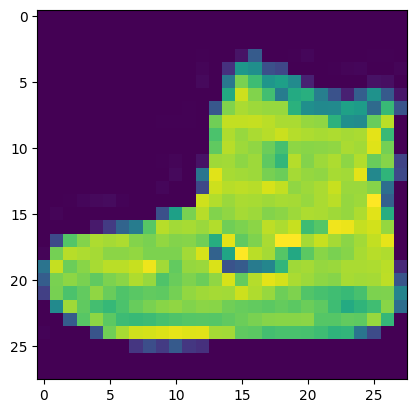

In [2]:
(X_train, y_train),(X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
plt.imshow(X_train[0])

`I will take half dataset only`

In [3]:
indices = np.random.permutation(X_train.shape[0])
X_train = X_train[indices[:len(X_train)//2]]

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5
X_train.shape

(30000, 28, 28, 1)

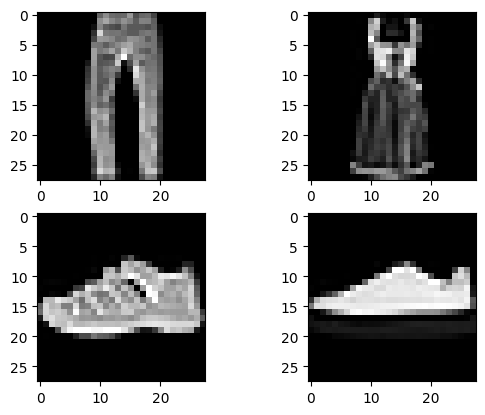

In [5]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [6]:
X_train.max(),X_train.min()

(1.0, -1.0)

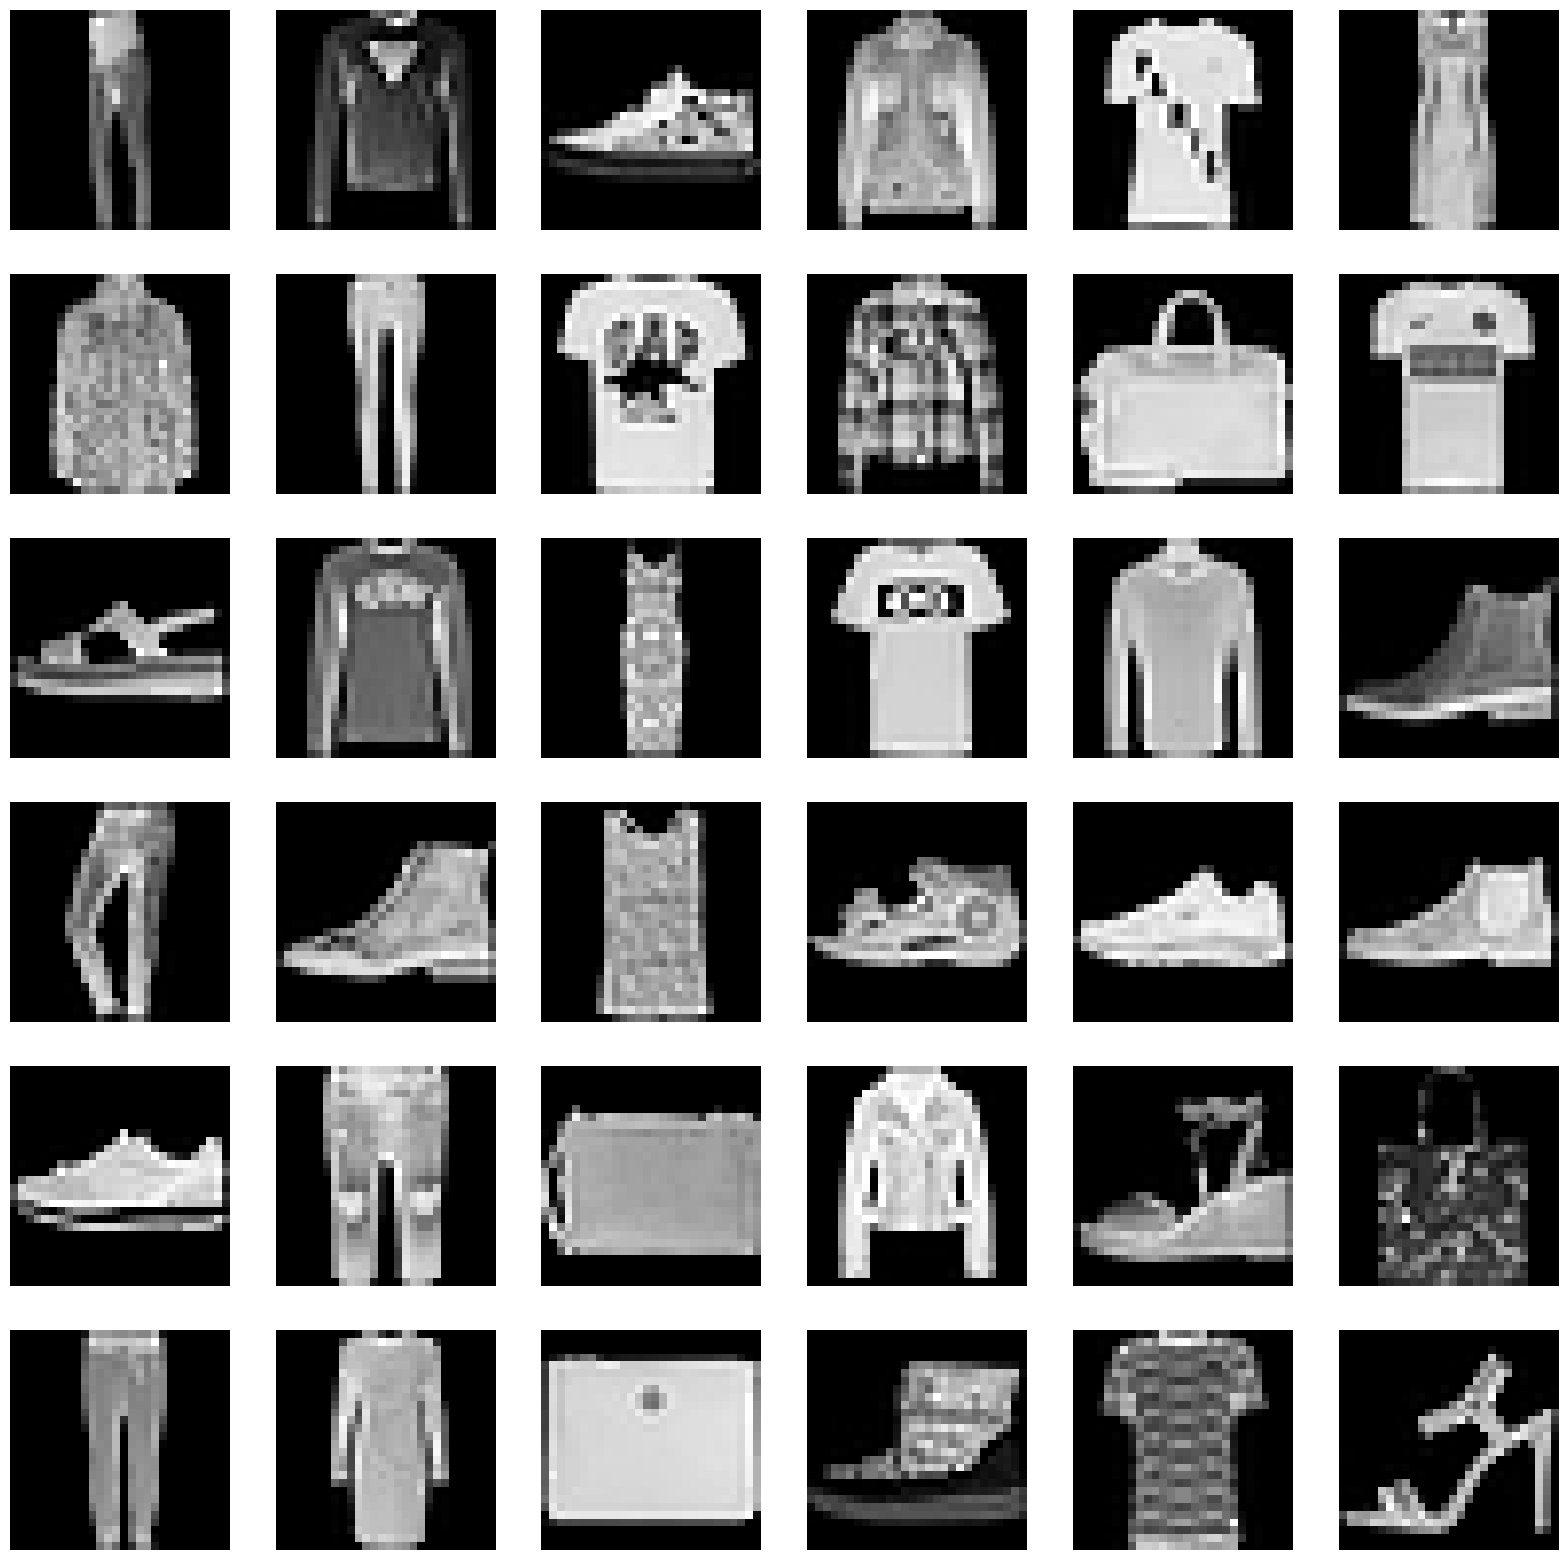

In [7]:
plt.figure(figsize=(20,20))

for n , i in enumerate(np.random.randint(0,len(X_train),36)) :
    plt.subplot(6,6,n+1)
    plt.imshow(X_train[i] ,cmap ='gray')
    plt.axis('off')


In [8]:
noise_dim =100
epochs =200
BATCH_SIZE = 128
lambda_gp = 10
img_size= 28

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

* Generator

In [10]:
def make_generator_model():
    model = Sequential([
        # Start with a dense layer and reshape to a smaller size
        Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim,)),
        BatchNormalization(),
        LeakyReLU(),

        Reshape((7, 7, 256)),

        # Upsample to 14x14
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        # Upsample to 28x28
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),


        # Final layer: produce output with shape (28, 28, 1)
        Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'),
    ])
    return model

* Discriminator

In [11]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, 1]),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

In [12]:
def gradient_penalty(real_images, fake_images):
    epsilon = tf.random.uniform([real_images.shape[0], 1, 1, 1], dtype=real_images.dtype)
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty

In [13]:
def discriminator_loss(real_output, fake_output, gp):
    real_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
    total_loss = real_loss + lambda_gp * gp
    return total_loss


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)



# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [14]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gp = gradient_penalty(images, fake_images)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, gp)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}", '=' * 40)
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
        print(f"Generator loss: {gen_loss:.4f}, Discriminator loss: {disc_loss:.4f}")

# Train the model
train(dataset, epochs)

Epoch 1/200 ========================================
Generator loss: 4.2832, Discriminator loss: -2.3085
Epoch 2/200 ========================================
Generator loss: -5.7455, Discriminator loss: 1.0109
Epoch 3/200 ========================================
Generator loss: -2.9083, Discriminator loss: -0.1427
Epoch 4/200 ========================================
Generator loss: -1.5035, Discriminator loss: 0.3671
Epoch 5/200 ========================================
Generator loss: -2.9137, Discriminator loss: -0.5215
Epoch 6/200 ========================================
Generator loss: -2.0132, Discriminator loss: -1.3415
Epoch 7/200 ========================================
Generator loss: -1.7538, Discriminator loss: -1.2392
Epoch 8/200 ========================================
Generator loss: 0.3704, Discriminator loss: -2.2597
Epoch 9/200 ========================================
Generator loss: 0.5484, Discriminator loss: -2.3151
Epoch 10/200 ======================================

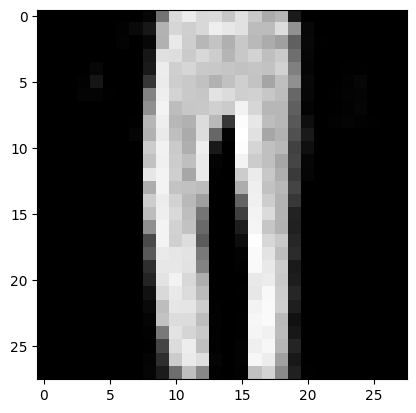

In [16]:
import matplotlib.pyplot as plt

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
reshaped_image = tf.reshape(generated_image, (img_size, img_size))  # Reshape using TensorFlow

plt.imshow(reshaped_image, cmap='gray')
plt.show()

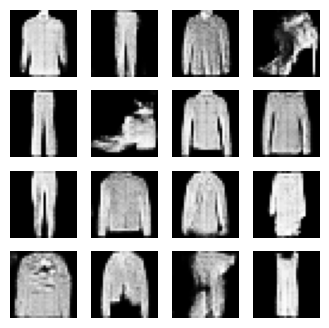

In [17]:
# Save the generator weights to a file
generator.save_weights('generator_weights.weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([16, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Rescale the images from [-1, 1] to [0, 1] before displaying
    plt.imshow((generated_images[i] * 0.5 + 0.5).numpy(), cmap='gray')
    plt.axis('off')
plt.show()